## To Predict Chronic Pain Among Patients Admitted to ICU 

Chronic Pain - Any etiology of chronic pain (including fibromyalgia) requiring long-term opiod/narcotic medication to control.

### Part I: Data Preprocessing

### Import packages

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Adjust notebook settings to widen the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

### Import modules/datasets

In [2]:
# every unique hospitalization for each patient in the database (defines HADM_ID_
admissions = pd.read_csv('data/ADMISSIONS.csv')
# every unique patient in the database (defines subject_id)
patients = pd.read_csv("data/PATIENTS.csv")
# the clinical service under which a patient is registered
services = pd.read_csv("data/SERVICES.csv")
# Diagnosis Related Groups (DRG), which are used by the hospital for billing purposes.
drgcodes = pd.read_csv("data/DRGCODES.csv")
# Deidentified notes, including nursing and physician notes, ECG reports, imaging reports, and discharge summaries.
noteevents = pd.read_csv("data/NOTEEVENTS.csv")
# Medications ordered, and not necessarily administered, for a given patient
prescriptions = pd.read_csv("data/PRESCRIPTIONS.csv")
# Ground truth dataset
phenotypes = pd.read_csv("data/GROUND_TRUTH.csv")

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# lowercase all strings inside of a dataframe to lowercase
admissions = admissions.apply(lambda x: x.astype(str).str.lower())
drgcodes = drgcodes.apply(lambda x: x.astype(str).str.lower())
noteevents = noteevents.apply(lambda x: x.astype(str).str.lower())
patients = patients.apply(lambda x: x.astype(str).str.lower())
services = services.apply(lambda x: x.astype(str).str.lower())
prescriptions = prescriptions.apply(lambda x: x.astype(str).str.lower())
phenotypes = phenotypes.apply(lambda x: x.astype(str).str.lower())

# lowercase columns in all dataframes
admissions.columns = admissions.columns.str.lower()
drgcodes.columns = drgcodes.columns.str.lower()
noteevents.columns = noteevents.columns.str.lower()
patients.columns = patients.columns.str.lower()
services.columns = services.columns.str.lower()
prescriptions.columns = prescriptions.columns.str.lower()
phenotypes.columns = phenotypes.columns.str.lower()

In [88]:
# decrease the datasets by subsetting the records which ID is in phenotypes dataset
admissions_reduced = admissions[admissions['subject_id'].isin(phenotypes['subject_id'])]
drgcodes_reduced = drgcodes[drgcodes['subject_id'].isin(phenotypes['subject_id'])]
noteevents_reduced = noteevents[noteevents['subject_id'].isin(phenotypes['subject_id'])]
patients_reduced = patients[patients['subject_id'].isin(phenotypes['subject_id'])]
services_reduced = services[services['subject_id'].isin(phenotypes['subject_id'])]
prescriptions_reduced = prescriptions[prescriptions['subject_id'].isin(phenotypes['subject_id'])]

admissions_reduced = admissions_reduced.reset_index(drop=True)
drgcodes_reduced = drgcodes_reduced.reset_index(drop=True)
noteevents_reduced = noteevents_reduced.reset_index(drop=True)
patients_reduced = patients_reduced.reset_index(drop=True)
services_reduced = services_reduced.reset_index(drop=True)
prescriptions_reduced = prescriptions_reduced.reset_index(drop=True)

### Attributes Included

Link: https://mimic.mit.edu/docs/iii/tables/ 

In [89]:
admissions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

**SUBJECT_ID, HADM_ID**
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.

**ADMITTIME, DISCHTIME, DEATHTIME**
ADMITTIME provides the date and time the patient was admitted to the hospital, while DISCHTIME provides the date and time the patient was discharged from the hospital. If applicable, DEATHTIME provides the time of in-hospital death for the patient. Note that DEATHTIME is only present if the patient died in-hospital, and is almost always the same as the patient’s DISCHTIME. However, there can be some discrepancies due to typographical errors.

**ADMISSION_TYPE**
ADMISSION_TYPE describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’. Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies. Elective indicates a previously planned hospital admission. Newborn indicates that the HADM_ID pertains to the patient’s birth.

**ADMISSION_LOCATION**
ADMISSION_LOCATION provides information about the previous location of the patient prior to arriving at the hospital. There are 9 possible values:

* EMERGENCY ROOM ADMIT
* TRANSFER FROM HOSP/EXTRAM
* TRANSFER FROM OTHER HEALT
* CLINIC REFERRAL/PREMATURE
* ** INFO NOT AVAILABLE **
* TRANSFER FROM SKILLED NUR
* TRSF WITHIN THIS FACILITY
* HMO REFERRAL/SICK
* PHYS REFERRAL/NORMAL DELI

The truncated text occurs in the raw data.

**INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY**
The INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY columns describe patient demographics. These columns occur in the ADMISSIONS table as they are originally sourced from the admission, discharge, and transfers (ADT) data from the hospital database. The values occasionally change between hospital admissions (HADM_ID) for a single patient (SUBJECT_ID). This is reasonable for some fields (e.g. MARITAL_STATUS, RELIGION), but less reasonable for others (e.g. ETHNICITY).

**EDREGTIME, EDOUTTIME**
Time that the patient was registered and discharged from the emergency department.

**DIAGNOSIS**
The DIAGNOSIS column provides a preliminary, free text diagnosis for the patient on hospital admission. The diagnosis is usually assigned by the admitting clinician and does not use a systematic ontology. As of MIMIC-III v1.0 there were 15,693 distinct diagnoses for 58,976 admissions. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the DIAGNOSES_ICD table. While this field can provide information about the status of a patient on hospital admission, it is not recommended to use it to stratify patients.

**HOSPITAL_EXPIRE_FLAG**
This indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge.

In [6]:
drgcodes.columns

Index(['row_id', 'subject_id', 'hadm_id', 'drg_type', 'drg_code',
       'description', 'drg_severity', 'drg_mortality'],
      dtype='object')

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**DRG_TYPE**
DRG_TYPE provides the type of DRG code in the entry. There are two types of DRG codes in the database which have overlapping ranges but distinct definitions for the codes. The three types of DRG codes in the MIMIC-III database are ‘HCFA’ (Health Care Financing Administration), ‘MS’ (Medicare), and ‘APR’ (All Payers Registry).

**DRG_CODE**
DRG_CODE contains a code which represents the diagnosis billed for by the hospital.

**DESCRIPTION**
DESCRIPTION provides a human understandable summary of the meaning of the given DRG code. The description field frequently has acronyms which represent comorbidity levels (comorbid conditions or “CC”). The following table provides a definition for some of these acronyms:

Acronym	Description
* w CC/MCC	with CC or Major CC
* w MCC	with Major CC
* w CC	with CC and without Major CC
* w NonCC	with NonCC and without CC or Major CC
* w/o MCC	with CC or Non CC and without Major CC
* w/o CC/MCC	with nonCC and without CC or Major CC

Note that there are three levels of comorbidities: none, with comorbid conditions, and with major comorbid conditions. These acronyms are primarily used in HCFA/MS DRG codes.

**DRG_SEVERITY, DRG_MORTALITY, DRG_SEVERITY and DRG_MORTALITY**
provide additional granularity to DRG codes in the ‘APR’ DRG type. Severity and mortality allow for higher billing costs when a diagnosis is more severe, and vice versa.

In [7]:
noteevents.columns

Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'storetime', 'category', 'description', 'cgid', 'iserror', 'text'],
      dtype='object')

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**CHARTDATE, CHARTTIME, STORETIME**
CHARTDATE records the date at which the note was charted. CHARTDATE will always have a time value of 00:00:00.

CHARTTIME records the date and time at which the note was charted. If both CHARTDATE and CHARTTIME exist, then the date portions will be identical. All records have a CHARTDATE. A subset are missing CHARTTIME. More specifically, notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, and ‘Echo’ never have a CHARTTIME, only CHARTDATE. Other categories almost always have both CHARTTIME and CHARTDATE, but there is a small amount of missing data for CHARTTIME (usually less than 0.5% of the total number of notes for that category).

STORETIME records the date and time at which a note was saved into the system. Notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, ‘Radiology’, and ‘Echo’ never have a STORETIME. All other notes have a STORETIME.

**CATEGORY, DESCRIPTION**
CATEGORY and DESCRIPTION define the type of note recorded. For example, a CATEGORY of ‘Discharge summary’ indicates that the note is a discharge summary, and the DESCRIPTION of ‘Report’ indicates a full report while a DESCRIPTION of ‘Addendum’ indicates an addendum (additional text to be added to the previous report).

**CGID**
CGID is the identifier for the caregiver who input the note.

**ISERROR**
A ‘1’ in the ISERROR column indicates that a physician has identified this note as an error.

**TEXT**
TEXT contains the note text.

In [8]:
patients.columns

Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag'],
      dtype='object')

**SUBJECT_ID**
SUBJECT_ID is a unique identifier which specifies an individual patient. SUBJECT_ID is a candidate key for the table, so is unique for each row. Information that is consistent for the lifetime of a patient is stored in this table.

**GENDER**
GENDER is the genotypical sex of the patient.

**DOB**
DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.

**DOD, DOD_HOSP, DOD_SSN**
DOD is the date of death for the given patient. DOD_HOSP is the date of death as recorded in the hospital database. DOD_SSN is the date of death from the social security database. Note that DOD merged together DOD_HOSP and DOD_SSN, giving priority to DOD_HOSP if both were recorded.

**EXPIRE_FLAG**
EXPIRE_FLAG is a binary flag which indicates whether the patient died, i.e. whether DOD is null or not. These deaths include both deaths within the hospital (DOD_HOSP) and deaths identified by matching the patient to the social security master death index (DOD_SSN).

In [9]:
services.columns

Index(['row_id', 'subject_id', 'hadm_id', 'transfertime', 'prev_service',
       'curr_service'],
      dtype='object')

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**TRANSFERTIME**
TRANSFERTIME is the time at which the patient moved from the PREV_SERVICE (if present) to the CURR_SERVICE.

**PREV_SERVICE, CURR_SERVICE**
PREV_SERVICE and CURR_SERVICE are the previous and current service that the patient resides under.


**Service	Description**

**CMED**	Cardiac Medical - for non-surgical cardiac related admissions

**CSURG**	Cardiac Surgery - for surgical cardiac admissions

**DENT**	Dental - for dental/jaw related admissions

**ENT**	Ear, nose, and throat - conditions primarily affecting these areas

**GU**	Genitourinary - reproductive organs/urinary system

**GYN**	Gynecological - female reproductive systems and breasts

**MED**	Medical - general service for internal medicine

**NB**	Newborn - infants born at the hospital

**NBB**	Newborn baby - infants born at the hospital

**NMED**	Neurologic Medical - non-surgical, relating to the brain

**NSURG**	Neurologic Surgical - surgical, relating to the brain

**OBS**	Obstetrics - conerned with childbirth and the care of women giving birth

**ORTHO**	Orthopaedic - surgical, relating to the musculoskeletal system

**OMED**	Orthopaedic medicine - non-surgical, relating to musculoskeletal system

**PSURG**	Plastic - restortation/reconstruction of the human body (including cosmetic or aesthetic)

**PSYCH**	Psychiatric - mental disorders relating to mood, behaviour, cognition, or perceptions

**SURG**	Surgical - general surgical service not classified elsewhere

**TRAUM**	Trauma - injury or damage caused by physical harm from an external source

**TSURG**	Thoracic Surgical - surgery on the thorax, located between the neck and the abdomen

**VSURG**	Vascular Surgical - surgery relating to the circulatory system

In [10]:
prescriptions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'startdate', 'enddate',
       'drug_type', 'drug', 'drug_name_poe', 'drug_name_generic',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'dose_val_rx',
       'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'route'],
      dtype='object')

**SUBJECT_ID, HADM_ID, ICUSTAY_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient, HADM_ID is unique to a patient hospital stay and ICUSTAY_ID is unique to a patient ICU stay.

**STARTDATE, ENDDATE**
STARTDATE and ENDDATE specify the date period for which the prescription was valid.

**DRUG_TYPE**
DRUG_TYPE provides the type of drug prescribed.

**DRUG, DRUG_NAME_POE, DRUG_NAME_GENERIC**
These columns are various representations of the drug prescribed to the patient.

**FORMULARY_DRUG_CD, GSN, NDC**
These columns provide a representation of the drug in various coding systems. GSN is the Generic Sequence Number. NDC is the National Drug Code

**PROD_STRENGTH
DOSE_VAL_RX, DOSE_UNIT_RX
FORM_VAL_DISP, FORM_UNIT_DISP**

**ROUTE**
The route prescribed for the drug.

### Functions

In [6]:
# function to get unique values
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

### Clean dataset: phenotypes

In [90]:
# Only keep the interested outcome feature
phenotypes_reduced = phenotypes[['hadm_id','subject_id','chronic.pain.fibromyalgia']]
# Drop duplicated records by subject_id and hadm_id
phenotypes_reduced = phenotypes_reduced.drop_duplicates(subset=['subject_id','hadm_id'], ignore_index = True)

In [91]:
# Size of phenotypes_reduced
phenotypes_reduced.shape

(813, 3)

In [92]:
phenotypes_reduced.head()

,hadm_id,subject_id,chronic.pain.fibromyalgia
0,100103,3365,0
1,100137,27290,0
2,100473,5525,0
3,100485,41515,0
4,100548,2265,0


In [93]:
phenotypes['chronic.pain.fibromyalgia'].value_counts()

0    1979
1     297
Name: chronic.pain.fibromyalgia, dtype: int64

### Clean dataset: admissions

#### Regarding diagnosis feature from admission: 

15,693 distinct diagnoses for 58,976 admissions. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the DIAGNOSES_ICD table. While this field can provide information about the status of a patient on hospital admission, it is not recommended to use it to stratify patients.


In [94]:
# Size of admissions_reduced
admissions_reduced.shape

(1944, 19)

In [95]:
# Since the dates and times from the database are deidentified -- create new features to get the time difference
admissions_reduced['edouttime'] = pd.to_datetime(admissions_reduced['edouttime'])
admissions_reduced['edregtime'] = pd.to_datetime(admissions_reduced['edregtime'])
admissions_reduced['length_ed'] = (admissions_reduced['edouttime'] - admissions_reduced['edregtime']).dt.days
admissions_reduced['dischtime'] = pd.to_datetime(admissions_reduced['dischtime'])
admissions_reduced['admittime'] = pd.to_datetime(admissions_reduced['admittime'])
admissions_reduced['length_admit'] = (admissions_reduced['dischtime'] - admissions_reduced['admittime']).dt.days
# Drop time-related features used to create new features
admissions_reduced = admissions_reduced.drop(['edregtime', 'edouttime', 'dischtime', 'admittime'], axis = 1)

In [96]:
# Create aggregate, dummy, and new variables for admission df to create one row per id
just_dummies = pd.get_dummies(admissions_reduced['admission_type'], prefix='admission_type', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for admission location
just_dummies = pd.get_dummies(admissions_reduced['admission_location'], prefix='admission_loc', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for discharge location
just_dummies = pd.get_dummies(admissions_reduced['discharge_location'], prefix='discharge_loc', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for insurance
just_dummies = pd.get_dummies(admissions_reduced['insurance'], prefix='insurance', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for religions
just_dummies = pd.get_dummies(admissions_reduced['religion'], prefix='religion', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for language
just_dummies = pd.get_dummies(admissions_reduced['language'], prefix='language', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for marital_status
just_dummies = pd.get_dummies(admissions_reduced['marital_status'], prefix='marital_status', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for ethnicity
just_dummies = pd.get_dummies(admissions_reduced['ethnicity'], prefix='ethnicity', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)

In [97]:
# Remove features used to dummy variables
admissions_reduced = admissions_reduced.drop(['row_id', 'deathtime', 'diagnosis', 'religion', 'language','marital_status', 'ethnicity', 'insurance', 'admission_location', 'discharge_location', 'admission_type'], axis = 1)

In [98]:
admissions_reduced["hospital_expire_flag"] = admissions_reduced.hospital_expire_flag.astype(float)
admissions_reduced["has_chartevents_data"] = admissions_reduced.has_chartevents_data.astype(float)

In [99]:
# Size of cleaned admissions_reduced dataset
admissions_reduced.shape

(1944, 90)

### Clean dataset: patients

In [100]:
# Size of patients_reduced dataset
patients_reduced.shape

(473, 8)

In [101]:
# Create numerical code for string variables in the gender feature
patients_reduced.gender[patients_reduced.gender == 'm'] = 1
patients_reduced.gender[patients_reduced.gender == 'f'] = 0

In [102]:
# Removing PIH features that had been deidentified
patients_reduced = patients_reduced.drop(['row_id', 'dob', 'dod', 'dod_hosp', 'dod_ssn'], axis = 1)

In [103]:
# Final features left for patients_reduced dataset
patients_reduced.head(2)

,subject_id,gender,expire_flag
0,690,1,1
1,704,1,1


### Cleaning dataset:  drgcodes

In [104]:
drgcodes_reduced.shape

(3883, 8)

In [105]:
drgcodes_reduced.head(3)

,row_id,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,383,6451,183196,hcfa,416,septicemia age >17,nan,nan
1,432,4655,143283,hcfa,304,"kidney, ureter & major bladder procedures for ...",nan,nan
2,26,23000,132906,hcfa,258,total mastectomy for malignancy without compli...,nan,nan


In [106]:
# Create dummy variables for drg_code
just_dummies = pd.get_dummies(drgcodes_reduced['drg_code'], prefix='drg_code', drop_first=True)
drgcodes_reduced = pd.concat([drgcodes_reduced, just_dummies], axis=1)

# Create dummy variables for drg_code
just_dummies = pd.get_dummies(drgcodes_reduced['drg_type'], prefix='drg_type', drop_first=True)
drgcodes_reduced = pd.concat([drgcodes_reduced, just_dummies], axis=1)

In [107]:
# Transform object to numerical features
drgcodes_reduced['drg_mortality'] = pd.to_numeric(drgcodes_reduced.drg_mortality, errors='coerce').fillna(0, downcast='infer').astype('Int32')
drgcodes_reduced['drg_severity'] = pd.to_numeric(drgcodes_reduced.drg_severity, errors='coerce').fillna(0, downcast='infer').astype('Int32')

In [108]:
# In order to have one record for each unique combination of subject_id and hadm_id, mean of the drg_mortality and drg_severity
# are calculated
drgcodes_reduced['avg_drg_mortality'] = drgcodes_reduced.groupby(['subject_id', 'hadm_id']).drg_mortality.transform('mean')
drgcodes_reduced['avg_drg_severity'] = drgcodes_reduced.groupby(['subject_id', 'hadm_id']).drg_severity.transform('mean')

In [109]:
drgcodes_reduced['avg_drg_mortality'] = drgcodes_reduced.avg_drg_mortality.astype(float)
drgcodes_reduced['avg_drg_severity'] = drgcodes_reduced.avg_drg_severity.astype(float)

In [110]:
# Drop duplicates by comparing subject_id and hadm_id
drgcodes_reduced = drgcodes_reduced.drop_duplicates(subset=['subject_id','hadm_id'], ignore_index = True)

In [111]:
drgcodes_reduced = drgcodes_reduced.drop(['row_id', 'description', 'drg_code', 'drg_type', 'drg_severity', 'drg_mortality' ], axis = 1)

In [112]:
# Final size of the drgcodes_reduced
drgcodes_reduced.shape

(1941, 641)

In [113]:
drgcodes_reduced.columns

Index(['subject_id', 'hadm_id', 'drg_code_10', 'drg_code_100', 'drg_code_101',
       'drg_code_104', 'drg_code_105', 'drg_code_106', 'drg_code_107',
       'drg_code_108',
       ...
       'drg_code_97', 'drg_code_974', 'drg_code_977', 'drg_code_981',
       'drg_code_987', 'drg_code_99', 'drg_type_hcfa', 'drg_type_ms',
       'avg_drg_mortality', 'avg_drg_severity'],
      dtype='object', length=641)

### Merge Datasets

In [114]:
phenotypes_reduced.shape

(813, 3)

In [115]:
main = pd.merge(admissions_reduced, phenotypes_reduced,
                how ='right',
                on = ['subject_id', 'hadm_id'])

main = pd.merge(main, patients_reduced,
                how ='left',
                on = ['subject_id'])

main = pd.merge(main, drgcodes_reduced,
                how ='left',
                on = ['subject_id', 'hadm_id'])

In [116]:
main["expire_flag"] = main.expire_flag.astype(float)
main['gender'] = main.gender.astype(int)

In [117]:
main.shape # final dataset (813, 742)

(813, 732)

In [118]:
main.to_csv('data/main.csv')

### Missingness of the final merged datasets

In [81]:
main.isnull().mean() # length_ed had ~30% missingness

subject_id                                  0.000000
hadm_id                                     0.000000
hospital_expire_flag                        0.000000
has_chartevents_data                        0.000000
length_ed                                   0.303813
length_admit                                0.000000
admission_type_elective                     0.000000
admission_type_emergency                    0.000000
admission_type_urgent                       0.000000
admission_loc_clinic referral/premature     0.000000
admission_loc_emergency room admit          0.000000
admission_loc_phys referral/normal deli     0.000000
admission_loc_transfer from hosp/extram     0.000000
admission_loc_transfer from other healt     0.000000
admission_loc_transfer from skilled nur     0.000000
discharge_loc_dead/expired                  0.000000
discharge_loc_disc-tran cancer/chldrn h     0.000000
discharge_loc_disch-tran to psych hosp      0.000000
discharge_loc_home                          0.

In [119]:
main['length_ed'] = main['length_ed'].fillna(0) # not entirely sure about this 

### Restructuring -- Move the outcome variable to be the last column in the dataset

In [120]:
cols = list(main.columns.values)
cols.pop(cols.index('chronic.pain.fibromyalgia'))
main = main[cols+['chronic.pain.fibromyalgia']]

In [121]:
main["hospital_expire_flag"] = main.hospital_expire_flag.astype(float)
main["has_chartevents_data"] = main.has_chartevents_data.astype(float)
main["expire_flag"] = main.expire_flag.astype(float)
main['gender'] = main.gender.astype(int)
main['avg_drg_mortality'] = main.avg_drg_mortality.astype(float)
main['avg_drg_severity'] = main.avg_drg_severity.astype(float)
main['chronic.pain.fibromyalgia'] = main['chronic.pain.fibromyalgia'].astype(int)

#### Set X as features and y as the outcome

In [122]:
df = main.drop(['subject_id', 'hadm_id'], axis = 1)

# High correlation filter

This dimensionality reduction algorithm tries to discard inputs that are very similar to others. In simple words, if your opinion is same as your boss, one of you is not required. If the value of two input parameters is always the same, it means they represent the same entity. Then we do not need two parameters there. Just one should be enough.

In technical words, if there is a very high correlation between two input variables, we can safely drop one of them.

In [123]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Top Absolute Correlations
language_hait                           ethnicity_black/haitian                    1.000000
avg_drg_mortality                       avg_drg_severity                           0.955766
religion_buddhist                       language_camb                              0.865491
language_engl                           language_nan                               0.824003
language_port                           ethnicity_white - brazilian                0.815993
discharge_loc_disch-tran to psych hosp  drg_code_7753                              0.815993
admission_type_emergency                admission_loc_phys referral/normal deli    0.811482
drg_type_hcfa                           avg_drg_severity                           0.797002
                                        avg_drg_mortality                          0.749346
ethnicity_hispanic/latino - guatemalan  drg_code_639                               0.706671
dtype: float64


In [126]:
# Removing highly correlated features
df = df.drop(['language_hait', 'avg_drg_severity', 'language_camb', 'language_nan', 'language_port'], axis = 1)

In [127]:
print(get_top_abs_correlations(df, 10))

discharge_loc_disch-tran to psych hosp  drg_code_7753                              0.815993
admission_type_emergency                admission_loc_phys referral/normal deli    0.811482
drg_type_hcfa                           avg_drg_mortality                          0.749346
ethnicity_hispanic/latino - guatemalan  drg_code_639                               0.706671
ethnicity_unable to obtain              drg_code_1664                              0.706671
ethnicity_portuguese                    drg_code_7753                              0.706671
language_cape                           ethnicity_black/cape verdean               0.706671
ethnicity_black/cape verdean            drg_code_1974                              0.706671
discharge_loc_hospice-medical facility  drg_code_1363                              0.706671
religion_muslim                         language_urdu                              0.705796
dtype: float64


In [143]:
y = df['chronic.pain.fibromyalgia']
y.shape

(813,)

In [144]:
y.value_counts() # imbalanced classes

0    702
1    111
Name: chronic.pain.fibromyalgia, dtype: int64

In [145]:
X = df.drop(['chronic.pain.fibromyalgia'], axis=1)
X.shape #(813, 724)

(813, 724)

## Splitting the dataset into the Training set and Test set¶

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## SMOTE

In [149]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['chronic.pain.fibromyalgia'])

# Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of not having chronic pain in oversampled data",len(os_data_y[os_data_y['chronic.pain.fibromyalgia']==0]))
print("Number of having chronic pain in oversampled data",len(os_data_y[os_data_y['chronic.pain.fibromyalgia']==1]))
print("Proportion of not having chronic in oversampled data is ",len(os_data_y[os_data_y['chronic.pain.fibromyalgia']==0])/len(os_data_X))
print("Proportion of having chronic pain in oversampled data is ",len(os_data_y[os_data_y['chronic.pain.fibromyalgia']==1])/len(os_data_X))

Length of oversampled data is  1118
Number of not having chronic pain in oversampled data 559
Number of having chronic pain in oversampled data 559
Proportion of not having chronic in oversampled data is  0.5
Proportion of having chronic pain in oversampled data is  0.5


## Recursive feature elimination

In [151]:
# df_vars = df.columns.values.tolist()
# y=['chronic.pain.fibromyalgia']
# X=[i for i in df_vars if i not in y]

# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression()
# rfe_20 = RFE(logreg, 20)
# rfe_20 = rfe_20.fit(os_data_X, os_data_y.values.ravel())

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (stat

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

## Feature Scaling - Standardization vs. Normalization

Feature scaling is essential for machine learning algorithms that calculate distances between data. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

* Normalization is recommended when you have a normally distributed observations.
* Standardization works all the time. (recommended)
* We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points.

* It is a good practice to fit the scaler on the training data and then use it to transform the testing data. This would avoid any data leakage during the model testing process. Also, the scaling of target values is generally not required.
* Only apply standardization to numerical columns and not the other One-Hot Encoded features. Standardizing the One-Hot encoded features would mean assigning a distribution to categorical features. You don’t want to do that! While it is fine to apply normalization to all kinds of columns including One-Hot Encorded features because One-Hot encoded features are already in the range between 0 to 1. So, normalization would not affect their value.

In [153]:
# Normalization 
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transofrm teting data
X_test_norm = norm.transform(X_test)

In [155]:
X_test.dtypes

hospital_expire_flag                        float64
has_chartevents_data                        float64
length_ed                                   float64
length_admit                                  int64
admission_type_emergency                      uint8
admission_type_urgent                         uint8
admission_loc_emergency room admit            uint8
admission_loc_phys referral/normal deli       uint8
admission_loc_transfer from hosp/extram       uint8
admission_loc_transfer from other healt       uint8
admission_loc_transfer from skilled nur       uint8
discharge_loc_disc-tran cancer/chldrn h       uint8
discharge_loc_disch-tran to psych hosp        uint8
discharge_loc_home                            uint8
discharge_loc_home health care                uint8
discharge_loc_home with home iv providr       uint8
discharge_loc_hospice-home                    uint8
discharge_loc_hospice-medical facility        uint8
discharge_loc_icf                             uint8
discharge_lo

In [156]:
# Standardization with sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = ['length_admit', 'avg_drg_mortality', 'expire_flag', 
            'hospital_expire_flag', 'has_chartevents_data']

# apply standardization on numerical features
for i in num_cols:
    scale = StandardScaler().fit(X_train_stand[[i]])
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

## Dimensionality Reduction

Dimensionality reduction is a data preparation technique performed on data prior to modeling. It might be performed after data cleaning and data scaling and before training a predictive model.

As such, any dimensionality reduction performed on training data must also be performed on new data, such as a test dataset, validation dataset, and data when making a prediction with the final model.

### Dimension Reduction Method I - Principal Component Analysis (PCA)

Standardization: All the variables should be on the same scale before applying PCA, otherwise, a feature with large values will dominate the result.

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
X_train_norm_pca = pca.fit_transform(X_train_norm)
X_test_norm_pca = pca.transform(X_test_norm)
X_train_stand_pca = pca.fit_transform(X_train_stand)
X_test_stand_pca = pca.transform(X_test_stand)

In [177]:
# Logistic Regression
model = LogisticRegression(random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

F1 score Raw: 0.16666666666666669
Recall score Raw: 0.1
Accuracy score Raw: 0.8773006134969326


F1 for Normalized: 0.1739130434782609
Recall for Normalized: 0.1
Accuracy score Normalized: 0.8834355828220859


F1 for Standardized: 0.16000000000000003
Recall for Standardized: 0.1
Accuracy score Standardized: 0.8711656441717791


F1 for PCA Normalized: 0.1739130434782609
Recall for PCA Normalized: 0.1
Accuracy score for PCA Normalized: 0.8834355828220859


F1 for PCA Standardized: 0.24
Recall for PCA Standardized: 0.15
Accuracy score for PCA Standardized: 0.8834355828220859




In [180]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

grid={"n_neighbors":range(2,10)}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

Best parameters:  {'n_neighbors': 6}


In [182]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

F1 score Raw: 0.24
Recall score Raw: 0.15
Accuracy score Raw: 0.8834355828220859


F1 for Normalized: 0.14814814814814817
Recall for Normalized: 0.1
Accuracy score Normalized: 0.8588957055214724


F1 for Standardized: 0.14814814814814817
Recall for Standardized: 0.1
Accuracy score Standardized: 0.8588957055214724


F1 for PCA Normalized: 0.21428571428571425
Recall for PCA Normalized: 0.15
Accuracy score for PCA Normalized: 0.8650306748466258


F1 for PCA Standardized: 0.21428571428571425
Recall for PCA Standardized: 0.15
Accuracy score for PCA Standardized: 0.8650306748466258




In [185]:
# Support Vector Machine
# Assumption: observations are linear
from sklearn.svm import SVC
model = SVC()

grid={'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf', 'sigmoid','poly'],'degree': [2,3,5,7]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

Best parameters:  {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [186]:
model = SVC(C=1, degree=2, gamma=0.1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

F1 score Raw: 0.18181818181818182
Recall score Raw: 0.1
Accuracy score Raw: 0.8895705521472392


F1 for Normalized: 0.18181818181818182
Recall for Normalized: 0.1
Accuracy score Normalized: 0.8895705521472392


F1 for Standardized: 0.18181818181818182
Recall for Standardized: 0.1
Accuracy score Standardized: 0.8895705521472392


F1 for PCA Normalized: 0.0
Recall for PCA Normalized: 0.0
Accuracy score for PCA Normalized: 0.8773006134969326


F1 for PCA Standardized: 0.18181818181818182
Recall for PCA Standardized: 0.1
Accuracy score for PCA Standardized: 0.8895705521472392




In [187]:
# Naive Bayes
# Advantages: This algorithm requires a small amount of training data to estimate the necessary parameters. 
# Naive Bayes classifiers are extremely fast compared to more sophisticated methods.

# Disadvantages: Naive Bayes is is known to be a bad estimator.

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

grid={'var_smoothing':[1e-11, 1e-10, 1e-9, 1e-8]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

Best parameters:  {'var_smoothing': 1e-11}


In [188]:
model = GaussianNB(var_smoothing=1e-11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

F1 score Raw: 0.29545454545454547
Recall score Raw: 0.65
Accuracy score Raw: 0.6196319018404908


F1 for Normalized: 0.29545454545454547
Recall for Normalized: 0.65
Accuracy score Normalized: 0.6196319018404908


F1 for Standardized: 0.29545454545454547
Recall for Standardized: 0.65
Accuracy score Standardized: 0.6196319018404908


F1 for PCA Normalized: 0.14285714285714288
Recall for PCA Normalized: 0.1
Accuracy score for PCA Normalized: 0.852760736196319


F1 for PCA Standardized: 0.16000000000000003
Recall for PCA Standardized: 0.1
Accuracy score for PCA Standardized: 0.8711656441717791




In [190]:
# Decision Tree
# Advantages: Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.
# Disadvantages: Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

grid={"splitter":['best', 'random'], "max_depth":[5,10,15,20], "min_samples_split": [5,10,15,20], "max_features":['auto', 'sqrt', 'log2']}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

Best parameters:  {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 20, 'splitter': 'best'}


In [193]:
model = DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_split=20, splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

F1 score Raw: 0.0
Recall score Raw: 0.0
Accuracy score Raw: 0.8773006134969326


F1 for Normalized: 0.0
Recall for Normalized: 0.0
Accuracy score Normalized: 0.8773006134969326


F1 for Standardized: 0.0
Recall for Standardized: 0.0
Accuracy score Standardized: 0.8773006134969326


F1 for PCA Normalized: 0.0
Recall for PCA Normalized: 0.0
Accuracy score for PCA Normalized: 0.8588957055214724


F1 for PCA Standardized: 0.13793103448275865
Recall for PCA Standardized: 0.1
Accuracy score for PCA Standardized: 0.8466257668711656




In [194]:
# Random Forest 
# Ensemble Learning : using different machine algorithms

# The algorithm does not work well for datasets having a lot of outliers, something which needs addressing prior to the model building.

# Advantages: Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.

# Disadvantages: Slow real time prediction, difficult to implement, and complex algorithm.

# Build on top of Decision Trees

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

grid={'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
     'max_features': ['auto', 'sqrt','log2'],
     'min_samples_split': [5,10,15,20],
     'n_estimators': [10, 20, 40, 60, 80, 100]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

Best parameters:  {'bootstrap': False, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 10}


F1 score Raw: 0.16666666666666669
Recall score Raw: 0.1
Accuracy score Raw: 0.8773006134969326


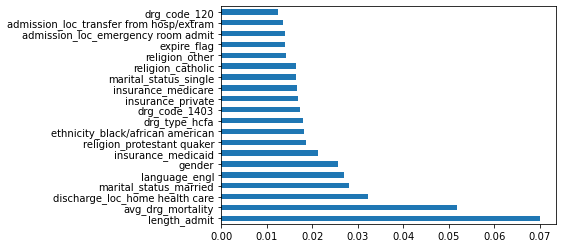

F1 for Normalized: 0.24
Recall for Normalized: 0.15
Accuracy score Normalized: 0.8834355828220859


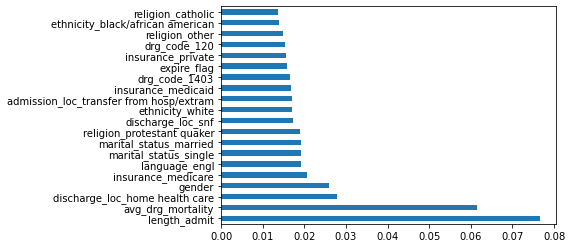

F1 for Standardized: 0.24
Recall for Standardized: 0.15
Accuracy score Standardized: 0.8834355828220859


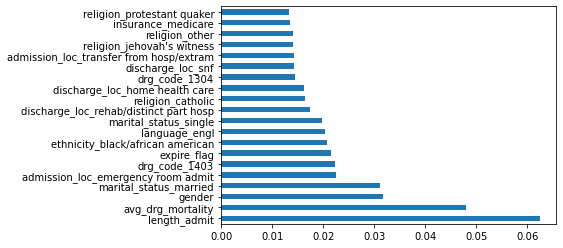

F1 for PCA Normalized: 0.3636363636363637
Recall for PCA Normalized: 0.3
Accuracy score for PCA Normalized: 0.8711656441717791


F1 for PCA Standardized: 0.35714285714285715
Recall for PCA Standardized: 0.25
Accuracy score for PCA Standardized: 0.8895705521472392


In [214]:
model = RandomForestClassifier(bootstrap=False, max_depth=80, max_features='log2', min_samples_split=5, n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))


In [ ]:
#XGBoost
model = xgb.XGBClassifier()

grid={'max_depth': [3, 5, 6, 10, 15, 20],
      'learning_rate': [0.01, 0.1, 0.2, 0.3],
      'subsample': np.arange(0.5, 1.0, 0.1),
      'colsample_bytree': np.arange(0.4, 1.0, 0.1),
      'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
      'n_estimators': [10, 50, 100, 150, 200, 500, 1000]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))

## Best scores for all algorithms:

**Logistic Regression**

**KNN**

**SVC**

**Naive Bayes: Gaussian**

**Decision Tree Classifier**

**Random Forest Classifier**

**XGBClassifier**